In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
header = [
    'RECORD_ID',
    'CAMPNO',
    'MAKETXT',
    'MODELTXT',
    'YEARTXT',
    'MFGCAMPNO',
    'COMPNAME',
    'MFGNAME',
    'BGMAN',
    'ENDMAN',
    'RCLTYPECD',
    'POTAFF',
    'ODATE',
    'INFLUENCED_BY',
    'MFGTXT',
    'RCDATE',
    'DATEA',
    'RPNO',
    'FMVSS',
    'DESC_DEFECT',
    'CONEQUENCE_DEFECT',
    'CORRECTIVE_ACTION',
    'NOTES',
    'RCL_CMPT_ID',
    'MFR_COMP_NAME',
    'MFR_COMP_DESC',
    'MFR_COMP_PTNO'
]

In [3]:
df = pd.read_csv('FLAT_RCL.txt', delimiter = '\t', encoding = 'latin-1', nrows = 154412, header = None, names = header, index_col='RECORD_ID', dtype = 'str')

### Plot frequency of term 'software' in corrective action text across time

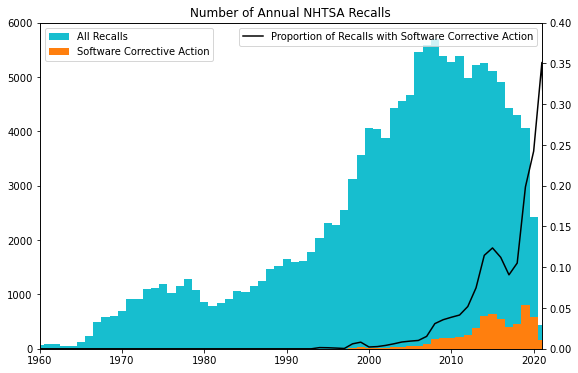

In [4]:
fig, ax1 = plt.subplots(figsize = (9, 6))
for series, label, color in zip(
    [
        df.loc[:,'YEARTXT'],
        df.loc[df['CORRECTIVE_ACTION'].fillna('').str.lower().str.contains('software'),'YEARTXT']
    ],
    [
        'All Recalls',
        'Software Corrective Action'
    ],
    ['tab:cyan', 'tab:orange']
):
    ax1.bar(
        series.astype('int').value_counts().index,
        series.astype('int').value_counts().values, 
        label = label, 
        width = 1,
        color = color
           )
ax2 = ax1.twinx()
ax2.plot(df.loc[df['CORRECTIVE_ACTION'].fillna('').str.lower().str.contains('software'),'YEARTXT'].astype('int').value_counts().div(df.loc[:,'YEARTXT'].astype('int').value_counts()).fillna(0),
         color = 'k',
        label = 'Proportion of Recalls with Software Corrective Action')
plt.xlim(1960, 2021)
ax1.set_ylim(0, 6000)
ax2.set_ylim(0, 0.4)
ax1.legend()
ax2.legend()
plt.title('Number of Annual NHTSA Recalls');

### Binary classification between before 2010 and after 2010:
- Logistic Regression
- Decision Trees

In [21]:
#Number of recalls after 2010
df.loc[df['YEARTXT'].astype('int') > 2010].shape[0]

55079

In [22]:
#Number of recalls before or during 2010
df.loc[df['YEARTXT'].astype('int') <= 2010].shape[0]

99332

### Simple logistic regression with text grams of corrective action text

In [162]:
cv = CountVectorizer(analyzer = "word",
                     token_pattern=r'\b[^\d\W]+\b', #https://datascience.stackexchange.com/questions/29352/sklearn-countvectorizer-token-pattern-skip-token-if-pattern-match
                     max_df = 0.4)

cv.fit_transform(df['CORRECTIVE_ACTION'].fillna(''))
'; '.join(cv.stop_words_)

'of; may; the; on; notify; dealers; owners; contact; to; began; and; will; free; charge; service; at; recall'

In [163]:
X_train, X_test, y_train, y_test = train_test_split(df['CORRECTIVE_ACTION'].fillna(''),
                                                    (df['YEARTXT'].astype('int') > 2010).astype('int'),
                                                    test_size = 0.25,
                                                    random_state = 273)

In [164]:
X_train_v = cv.fit_transform(X_train)
X_test_v = cv.transform(X_test)

In [165]:
lr = LogisticRegression()
lr.fit(X_train_v, y_train)

/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [166]:
lr.score(X_train_v, y_train), lr.score(X_test_v, y_test)

(0.9079165515335728, 0.9008367225345181)

In [195]:
new_ten = pd.DataFrame([cv.get_feature_names(), lr.coef_[0]]).T.rename(columns = {0: 'Token', 1: 'Coefficient'}).sort_values(by = 'Coefficient', ascending = False).head(10).sort_values(by = 'Coefficient', ascending = True)

In [196]:
old_ten = pd.DataFrame([cv.get_feature_names(), lr.coef_[0]]).T.rename(columns = {0: 'Token', 1: 'Coefficient'}).sort_values(by = 'Coefficient', ascending = False).tail(10)

In [224]:
colorseq = (
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
)

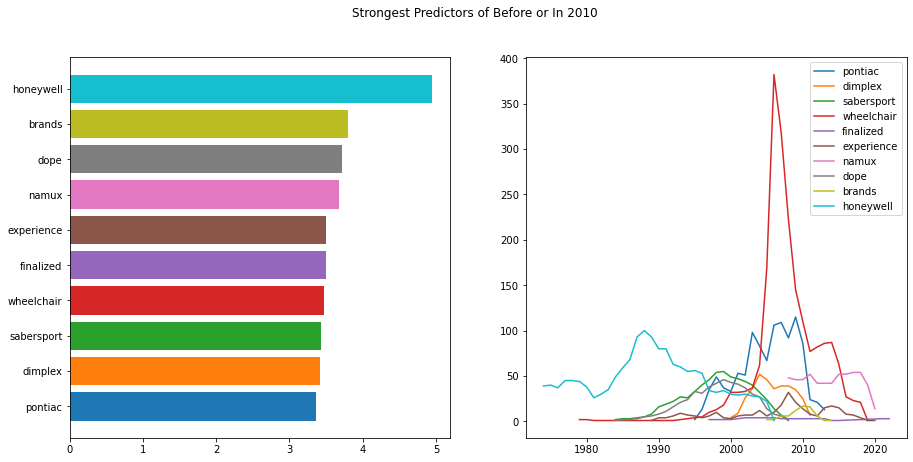

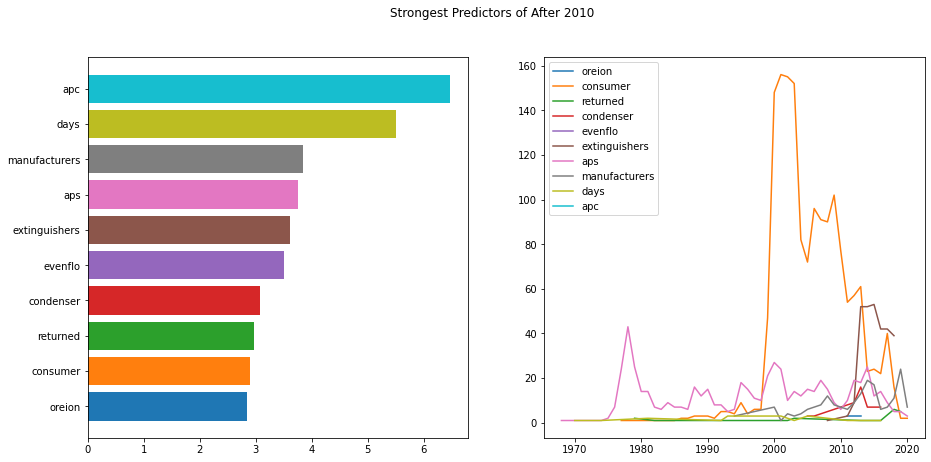

In [228]:
for d,t in zip(
    [old_ten, new_ten],
    ['Before or In', 'After']
):
    fig, ax = plt.subplots(1,2, figsize = (15, 7))
    ax = ax.ravel()
    ax[0].barh(width = np.abs(d['Coefficient']),
            y = d['Token'],
              color = colorseq);
    for token, color in zip(d['Token'], colorseq):
        ax[1].plot(df.loc[(df['YEARTXT'].astype('int') < 9999) & (df['CORRECTIVE_ACTION'].str.lower().str.contains(token).fillna(False)), 'YEARTXT'].astype('int').value_counts().sort_index(),
                label = token,
                  color = color)
    ax[1].legend();
    plt.suptitle(f"Strongest Predictors of {t} 2010")